In [1]:
%pip install pyroomacoustics

Note: you may need to restart the kernel to use updated packages.


This is just my first pass through, I haven't deleted it yet because I was using it as an example

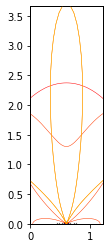

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pyroomacoustics as pra

# # Recreate Dr. Neilsen's water tank by inputting the correct dimensions
# room = pra.ShoeBox([1.22,3.66])

# # Add a source somewhere in the tank
# room.add_source([.61, 0])

# # Create a linear array beamformer with 4 microphones
# # with angle 0 degrees and inter mic distance 10 cm
# # R = pra.linear_2D_array([2, 1.5], 4, 0, 0.1)
# R = pra.linear_2D_array([.61, 0], 4, 0, 0.1)
# room.add_microphone_array(pra.Beamformer(R, room.fs))

# # Now compute the delay and sum weights for the beamformer
# room.mic_array.rake_delay_and_sum_weights(room.sources[0][:1])

# # plot the room and resulting beamformer
# room.plot(freq=[1000, 2000, 4000, 8000], img_order=0)
# plt.show()

This is the one I am actually working on with (hopefully) more helpful notes in the comments 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra

# Recreate Dr. Neilsen's water tank by inputting the correct dimensions
# I am trying to figure out how to make it so we can put absorption panels
# on the two walls, but not all 4. No luck so far. This material is closest to 
# polyurethane in their materials library- perforated_veneered_chipboard

room = pra.ShoeBox([1.22,3.66])
room.extrude(.91)

# Add a source somewhere in the tank, I just picked a random spot, feel free to change
room.add_source([.61, 0, .3])

# Create where the microphones are, I just said that it was where the sourse is since I think 
# in Dr. Neilsen's lab it works as both(I'm not 100% sure of that)
# with angle 0 degrees and inter mic distance 10 cm

mics = np.c_[[.61,0,.3]]
room.add_microphone_array(pra.Beamformer(mics, room.fs))
# room.add_microphone_array(mics)


# # Now compute the delay and sum weights for the beamformer (I don't know what this means)
room.mic_array.rake_delay_and_sum_weights(room.sources[0][:1])

# plot the room and resulting beamformer (I can't get this to work, but I didn't super have time to keep
# working on it, so it might not be that bad of a fix)
room.plot(freq=[1000, 2000, 4000, 8000], img_order=0)
plt.show()


AttributeError: 'Axes3D' object has no property 'auto_add_to_figure'

<Figure size 432x288 with 0 Axes>

Wave Equation, modeling boundary conditions in a tank
https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.room.html#pyroomacoustics.room.Room

Design of an underwater acoustics lab 
Cameron T. Vongsawad; 

https://hplgit.github.io/fdm-book/doc/pub/book/sphinx/._book008.html
https://github.com/LCAV/pyroomacoustics/blob/master/README.rst
https://m-sound.github.io/mSOUND/rigid_vs_pressure_release



